# Combine sgRNAs
Here we get a dataframe of all sgRNAs for all processed datasets to use for scoring

In [1]:
import pandas as pd
from datasets import dataset_list
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import gpplot
import seaborn as sns
import numpy as np

In [2]:
def add_xy_line(slope=1, intercept=0, ax=None, linestyle='dashed', linecolor='black'):
    """Add line with specified slope and intercept to a scatter plot; Default: y=x line

    Parameters
    ----------
    slope: float
        Value of slope of line to be drawn
    intercept: float
        Value of intercept of line to be drawn
    ax: Axis object, optional
        Plot to add line to
    linestyle: str, optional
        Style of line
    linecolor: str, optional
        Color of line

    Returns
    -------
    matplotlib.axes.Axes
    """
    if ax is None:
        ax = plt.gca()
    x = np.array(ax.get_xlim())
    y = intercept + slope * x
    ax = ax.plot(x, y, linestyle=linestyle, color=linecolor)
    return ax

We need to load the datasets first

In [3]:
for ds in dataset_list:
    ds.load_data()

In [4]:
dataset_summaries = []
for ds in dataset_list:
    ds_summary = dict()
    ds_summary['name'] = ds.name
    ds_summary['n_sgRNAs'] = ds.dataset.shape[0]
    if ds.sgrna_group_col is not None:
        ds_summary['n_groups'] = ds.dataset[ds.sgrna_group_col].nunique()
    dataset_summaries.append(ds_summary)

dataset_summary_df = pd.DataFrame(dataset_summaries)
dataset_summary_df.sort_values('n_sgRNAs')

,name,n_sgRNAs,n_groups
7,Kim2019_test,536,NaN
4,Doench2014_human,995,3.0
10,Wang_2014,1022,29.0
1,Chari2015,1145,NaN
3,Doench2014_mouse,1169,7.0
5,Doench2016,2536,8.0
2,DeWeirdt2020,3510,14.0
9,Shalem_2014,4766,1249.0
8,Koike-Yusa2014,6689,1437.0
0,Aguirre2017,8659,1532.0


## Overlap between datasets

For each dataset we'll calculate the fraction of sgRNAs that each library shares with one another

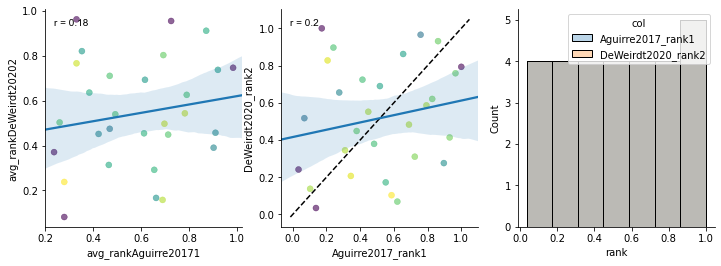

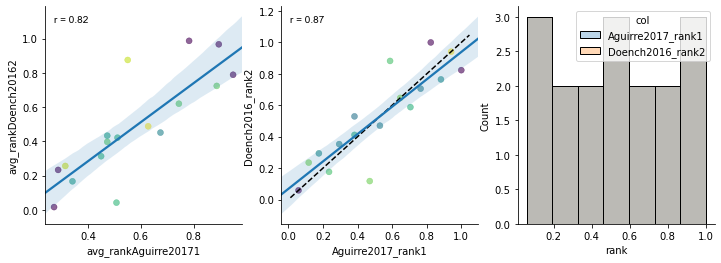

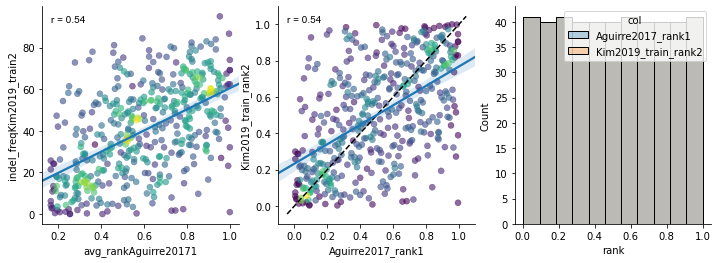

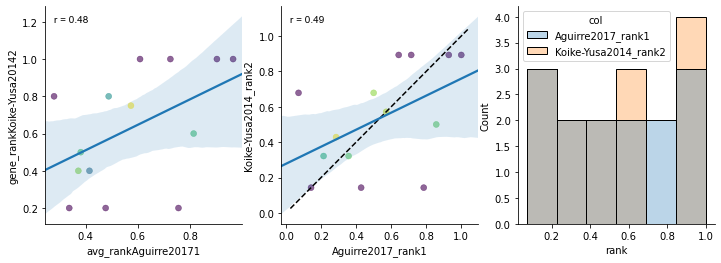

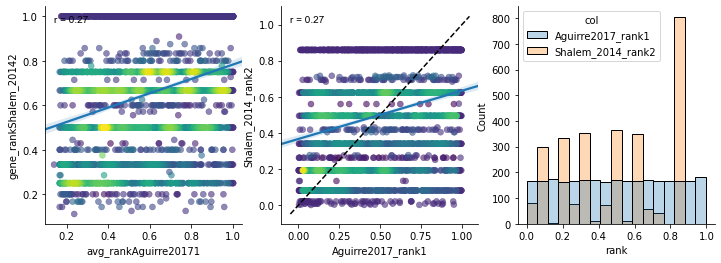

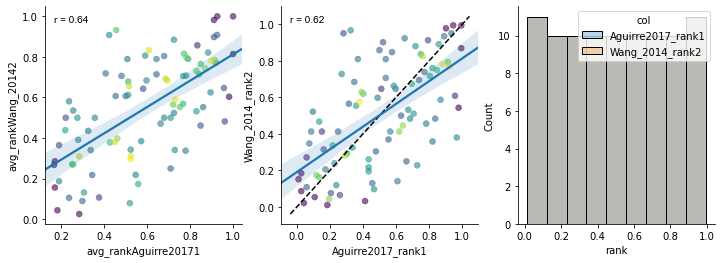

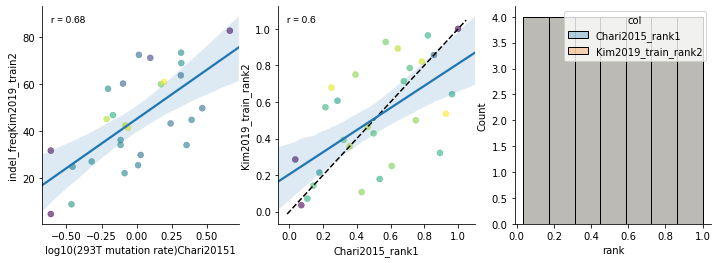

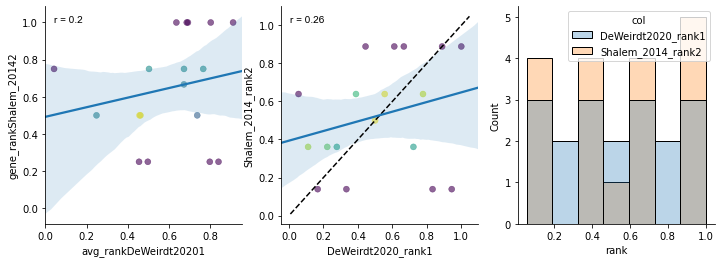

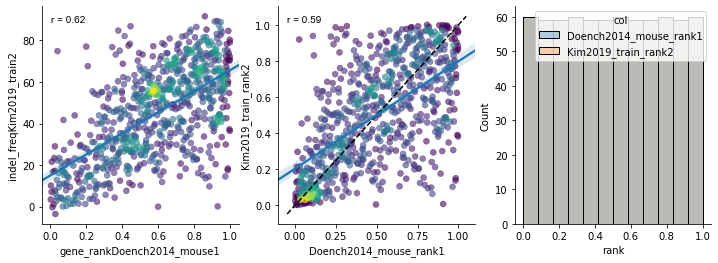

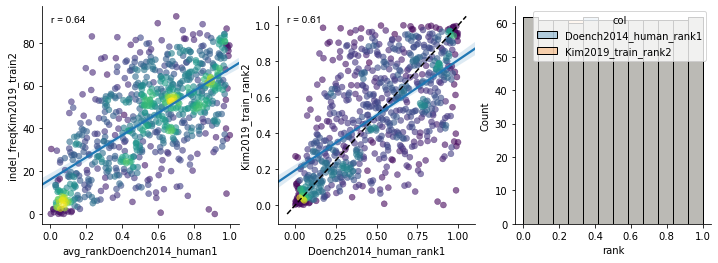

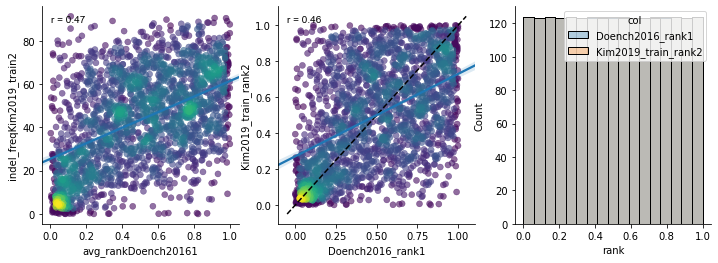

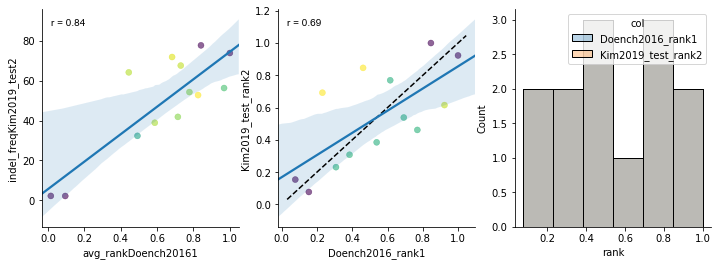

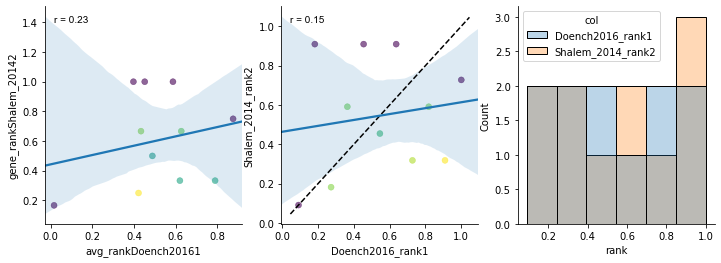

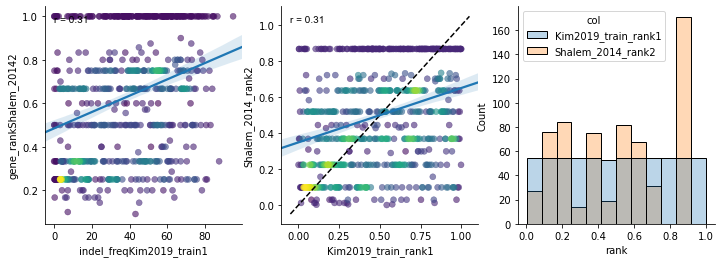

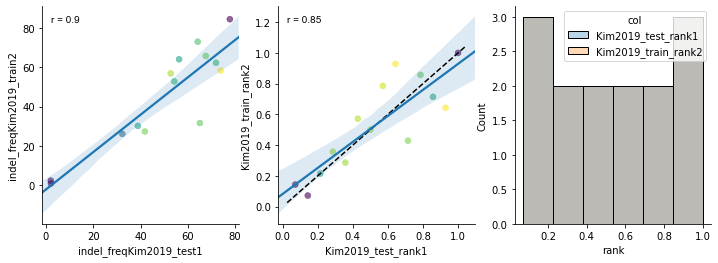

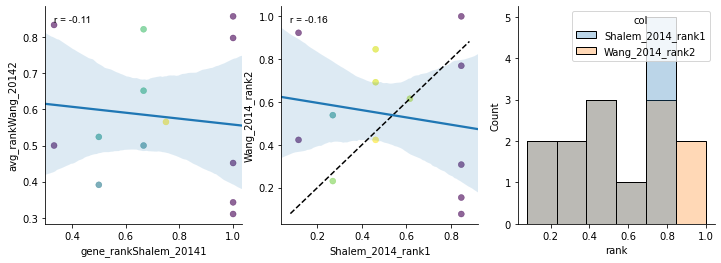

In [5]:
dataset_overlaps = []
for ds1 in dataset_list:
    for ds2 in dataset_list:
        if ds1 != ds2:
            dataset_overlap = dict()
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_context = (ds1.dataset[ds1.context_seq_col]
                              .isin(ds2.dataset[ds2.context_seq_col])
                              .sum())
            dataset_overlap['overlap'] = common_context
            if common_context > 10:
                merged_data = (ds1.dataset
                               .rename({ds1.rank_col: ds1.rank_col + ds1.name + '1'}, axis=1)
                               .merge(ds2.dataset
                                      .rename({ds2.rank_col: ds2.rank_col + ds2.name + '2'}, axis=1),
                                      how='inner',
                                      left_on=ds1.context_seq_col, right_on=ds2.context_seq_col))
                merged_data[ds1.name + '_rank1'] = merged_data[ds1.rank_col + ds1.name + '1'].rank(pct=True)
                merged_data[ds2.name + '_rank2'] = merged_data[ds2.rank_col + ds2.name + '2'].rank(pct=True)
                if ds1.name < ds2.name:
                    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
                    gpplot.point_densityplot(merged_data, x=ds1.rank_col + ds1.name + '1',
                                             y=ds2.rank_col + ds2.name + '2', ax=ax1)
                    gpplot.add_correlation(merged_data, x=ds1.rank_col + ds1.name + '1',
                                           y=ds2.rank_col + ds2.name + '2', ax=ax1)
                    sns.regplot(data=merged_data, x=ds1.rank_col + ds1.name + '1',
                                y=ds2.rank_col + ds2.name + '2', ax=ax1, truncate=False,
                                scatter=False)
                    sns.despine(ax=ax1)
                    gpplot.point_densityplot(merged_data, x=ds1.name + '_rank1',
                                             y=ds2.name + '_rank2', ax=ax2)
                    gpplot.add_correlation(merged_data, x=ds1.name + '_rank1',
                                           y=ds2.name + '_rank2', ax=ax2)
                    add_xy_line(ax=ax2)
                    sns.regplot(data=merged_data, x=ds1.name + '_rank1',
                                y=ds2.name + '_rank2', ax=ax2, truncate=False,
                                scatter=False)
                    sns.despine(ax=ax2)
                    sns.histplot(data = merged_data.melt(id_vars=[ds1.context_seq_col],
                                                         value_vars=[ds1.name + '_rank1',
                                                                     ds2.name + '_rank2'],
                                                         var_name='col', value_name='rank'),
                                 x='rank', hue='col', ax=ax3, alpha=0.3)
                    sns.despine(ax=ax3)


                cor = stats.pearsonr(merged_data[ds1.rank_col + ds1.name + '1'],
                                     merged_data[ds2.rank_col + ds2.name + '2'])[0]
                dataset_overlap['activity_cor'] = cor
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
filtered_overlap = dataset_overlap_df[dataset_overlap_df['overlap'] > 0].reset_index(drop=True)
filtered_overlap = (filtered_overlap.merge(dataset_summary_df
                                           .rename({'name': 'name_1'}, axis=1),
                                           how='inner', on='name_1'))
filtered_overlap['fraction_overlap'] = filtered_overlap['overlap']/filtered_overlap['n_sgRNAs']

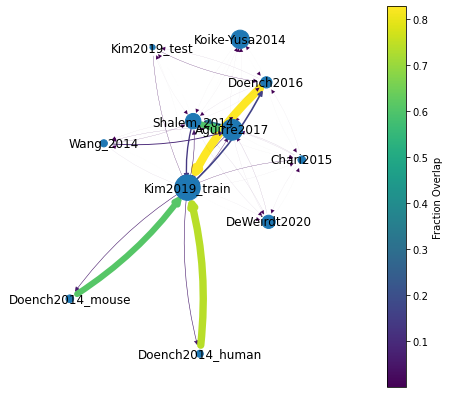

In [6]:
G = nx.from_pandas_edgelist(filtered_overlap, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (dataset_summary_df[['name', 'n_sgRNAs']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(8,7))
# layout
pos = nx.spring_layout(G, seed=7)
# edges
edge_width = [d['fraction_overlap']*10 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-|>", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.05 for n, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size)
# labels
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.margins(x=0.2)

## Getting list of all sgRNAs

In [7]:
sgrna_dfs_list = list()
for ds in dataset_list:
    sgrna_dfs_list.append(ds.get_sg_df())

sgrna_df = (pd.concat(sgrna_dfs_list)
            .drop_duplicates())

print(sgrna_df.shape[0])

36542


In [8]:
sgrna_df['PAM Sequence'].value_counts()

TGG    14031
AGG    12142
CGG     5909
GGG     4460
Name: PAM Sequence, dtype: int64

In [9]:
sgrna_df.to_csv('../data/interim/rs_dev_all_sgrnas.csv', index=False)
filtered_overlap.to_csv('../data/processed/dataset_overlap.csv', index=False)